In [23]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mne
from zipfile import ZipFile

In [24]:
import torch
import torch.nn as nn
import torcheeg as te

In [25]:
torch.__version__
torch.cuda.is_available()

True

In [26]:
!nvidia-smi

Thu Jul 27 17:44:51 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   64C    P8               1W /  50W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading data

In [78]:
image_metadata_path = os.path.join(path, 'image_set/image_metadata.npy')
image_metadata = np.load(image_metadata_path, allow_pickle=True).item()

In [85]:
image_metadata['train_img_concepts']

['00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00001_aardvark',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00002_abacus',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00003_accordion',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00004_acorn',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00005_air_conditioner',
 '00006_air_mattress

In [81]:
image_metadata.keys()

dict_keys(['test_img_concepts', 'test_img_concepts_THINGS', 'test_img_files', 'train_img_files', 'train_img_concepts', 'train_img_concepts_THINGS'])

In [50]:
### Load the EEG data
# data_part = 'training'
path = 'C:\\Users\\gianl\\Desktop\\THINGS EEG2\\eeg_dataset'

eeg_dir_train = os.path.join(path, 'preprocessed_data', 'sub-' + '01', 'preprocessed_eeg_' + 'training' + '.npy')
eeg_dir_test = os.path.join(path, 'preprocessed_data', 'sub-' + '01', 'preprocessed_eeg_' + 'test' + '.npy')

eeg_data_train = np.load(eeg_dir_train, allow_pickle=True).item()
eeg_data_test = np.load(eeg_dir_test, allow_pickle=True).item()

### MNE

In [28]:
### Convert to MNE raw format
ch_names = eeg_data['ch_names']
sfreq = 100 # Hz
eeg_data_pr = eeg_data['preprocessed_eeg_data'][0][0]

info = mne.create_info(ch_names, sfreq, 'eeg')
raw = mne.io.RawArray(eeg_data_pr, info)

Creating RawArray with float64 data, n_channels=17, n_times=100
    Range : 0 ... 99 =      0.000 ...     0.990 secs
Ready.


In [29]:
easycap_montage = mne.channels.make_standard_montage("easycap-M10") # sbagliato
print(easycap_montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 61 channels>


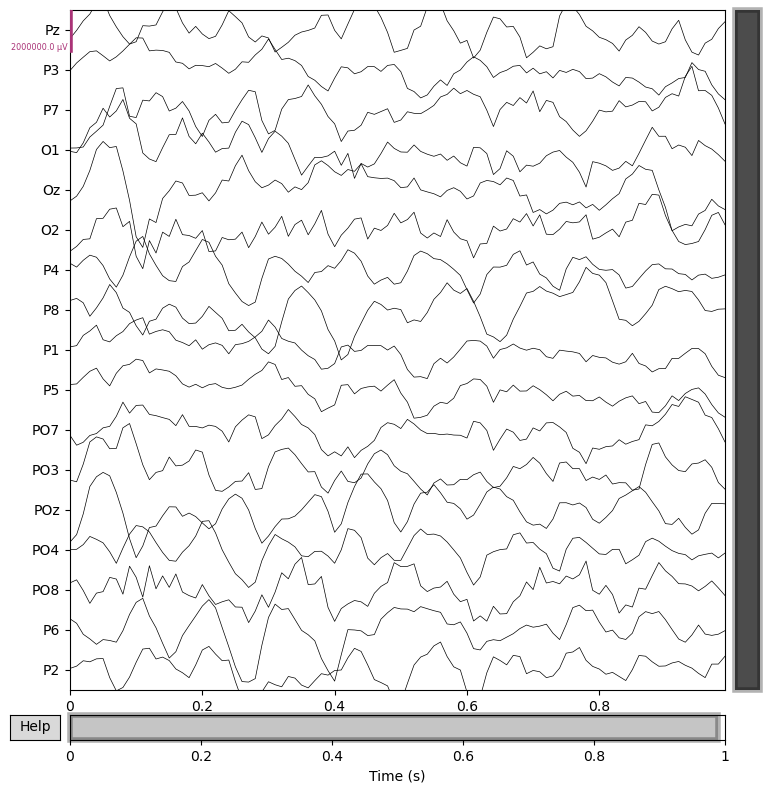

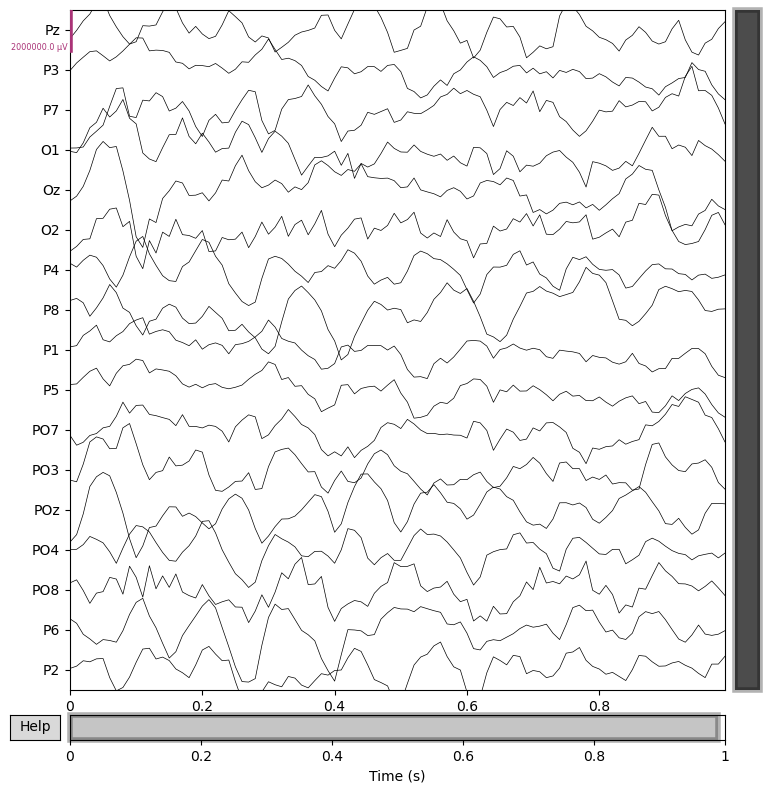

In [30]:
scalings = {'eeg': 1}
raw.plot(title='Data from arrays', show=True, block=True, scalings=scalings, n_channels = 17)

### THINGS-EEG2 data exploration

In [31]:
eeg_data.keys()

dict_keys(['preprocessed_eeg_data', 'ch_names', 'times'])

In [32]:
print(eeg_data['preprocessed_eeg_data'].shape)
# [[16,540 training image conditions][description] × 4 EEG repetitions × 17 EEG channels × 100 EEG time points]
print(len(eeg_data['ch_names']))
print(eeg_data['times'].shape)

# 16540 x 4 elementi di dimensione 17 x 100

(16540, 4, 17, 100)
17
(100,)


In [35]:
### Channel correlation

# plt.figure(figsize=(19, 15))
# fig = plt.matshow(torch.corrcoef(eeg_data_train['eeg'][0]), fignum=1, cmap='bwr')

### Label extraction

In [76]:
# Get list of files names in zip
def get_labels(partition):
    path_tmp = os.path.join(path, 'image_set', f'{partition}_images.zip')

    with ZipFile(path_tmp, 'r') as zipObj:
        # Get list of files names in zip
        files_list_tmp = zipObj.namelist()

    files_list_tmp.sort()
    labels_tmp = ['_'.join(elem.split('/')[2].split('_')[: -1]) for elem in files_list_tmp if elem.endswith('/') == False]

    labels_tmp = np.repeat(labels_tmp, 4 if partition == 'training' else 80)

    return labels_tmp

In [77]:
labels_train = get_labels('training')
labels_test = get_labels('test')

print(len(labels_train))
print(len(labels_test))

66160
16000


In [71]:
eeg_data_test['preprocessed_eeg_data'].shape
eeg_data_train['preprocessed_eeg_data'].shape

(16540, 4, 17, 100)

In [39]:
labels_train = np.repeat(labels_train, 4)
labels_train = np.repeat(labels_train, 80)

66160

In [40]:
labels

x = [eeg_data['preprocessed_eeg_data'][i][j] for i in range(16540) for j in range(4)]
x = np.array(x)
len(x)

66160

In [41]:
mean = np.mean(x, axis=0)

Creating RawArray with float64 data, n_channels=17, n_times=100
    Range : 0 ... 99 =      0.000 ...     0.990 secs
Ready.


<Figure size 1900x1500 with 0 Axes>

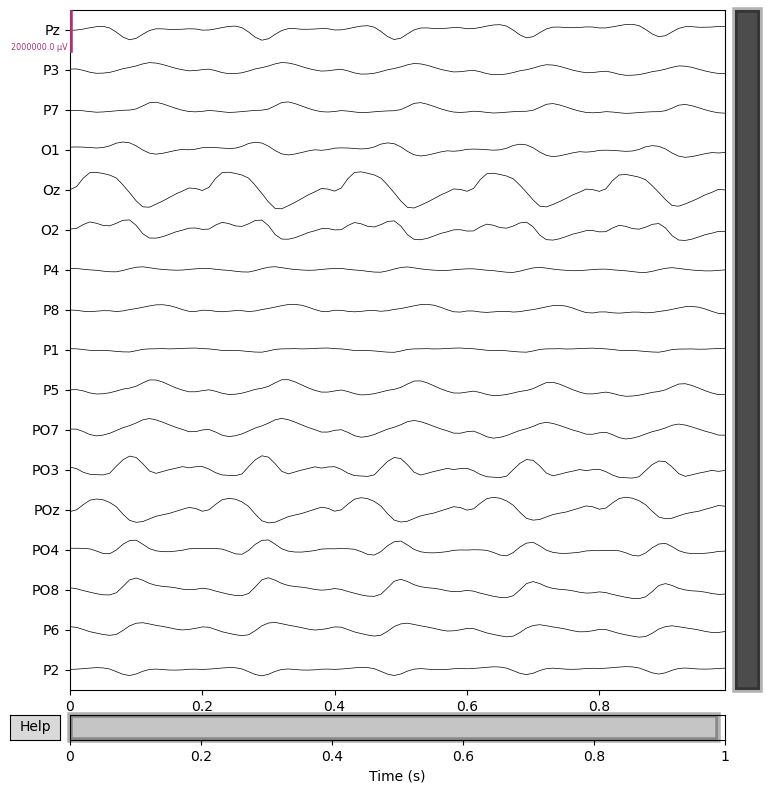

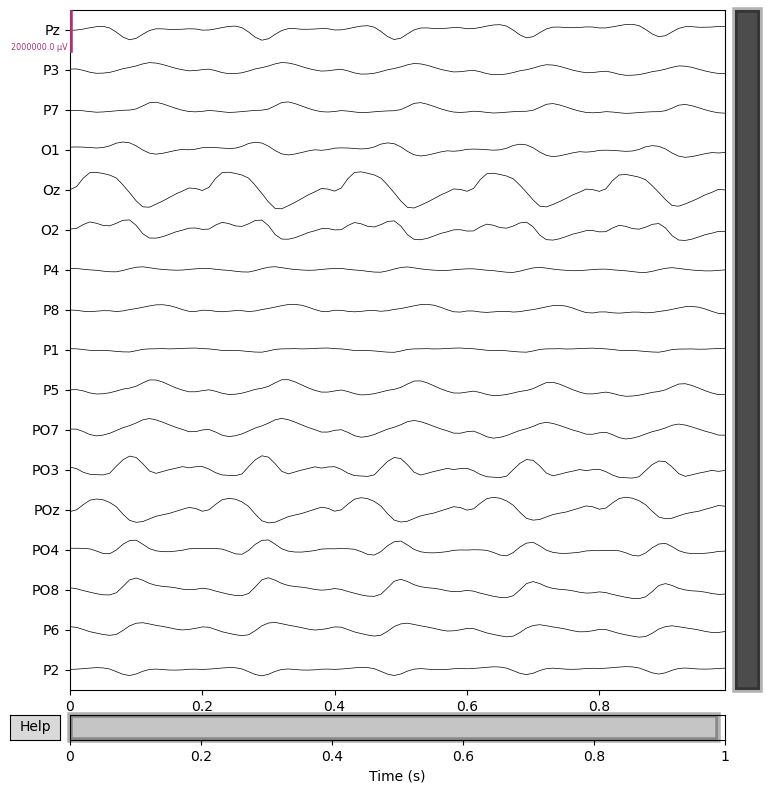

In [42]:
### Convert to MNE raw format
ch_names = eeg_data['ch_names']
sfreq = 100 # Hz
eeg_data = mean

info = mne.create_info(ch_names, sfreq, 'eeg')
raw = mne.io.RawArray(eeg_data, info)

scalings = {'eeg': 1}
raw.plot(title='Data from arrays', show=True, block=True, scalings=scalings, n_channels = 17)

### Classification

In [43]:
from torcheeg import models

In [44]:
models.EEGNet(chunk_size=100, num_electrodes=17, F1=8, F2=16, D=2, num_classes=2, kernel_1=64, kernel_2=16, dropout=0.25)

EEGNet(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Conv2dWithConstraint(8, 16, kernel_size=(17, 1), stride=(1, 1), groups=8, bias=False)
    (3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
    (6): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
    (5): Dropout(p=0.25, inplace=False)
  )
  (lin): Linear(in_features=48, out_features=2, bias=False)
)

In [45]:
# Define dataloader + splitting
# dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x, labels):
        'Initialization'
        self.labels = labels
        self.x = x

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index]
        y = self.labels[index]

        return X, y

In [49]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

# Generators
training_set = Dataset(x, labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

# Dataset(x, labels)

In [47]:
tensor_x = torch.Tensor(x) # transform to torch tensor
tensor_y = torch.Tensor(labels)

from torch.utils.data import TensorDataset, DataLoader
my_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()
batch_size = 64

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch_idx, batch in enumerate(dataloader):
        X = batch[0].to(device)
        y = batch[1].to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            loss, current = loss.item(), batch_idx * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

In [ ]:
for i, (train_dataset, val_dataset) in enumerate(k_fold.split(dataset)):

    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_loader, model, loss_fn, optimizer)
        valid(val_loader, model, loss_fn)
    print("Done!")